In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib,pprint,keras

import FBNN3d,sei_kume,myResNet
importlib.reload(FBNN3d)
importlib.reload(sei_kume)
importlib.reload(myResNet)
from FBNN3d import *
from sei_kume import *
from myResNet import *

# FBNN3d

In [3]:
(x_train,y_train) = gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=500,multi=100)
test_data = [gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=20,multi=100) for _ in range(5)]

In [4]:
layers=range(1,11)
hiddens=range(50,1501,50)
res=[]
for layer in layers:
    print('\nlayer:',layer,'\nhidden:',end=" ")
    for hidden in hiddens:
        model=set_model_3d(n_hidden=hidden,n_layer=layer,print_summary=False)
        model.fit(x_train, y_train, verbose=0, epochs=10,shuffle=True, validation_split=0.2)
        scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
        print(hidden, end=" ")
        score = np.mean(scores,axis=0)
        res.append([layer,hidden,score[0],score[1]])


layer: 1 
hidden: 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 
layer: 2 
hidden: 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 
layer: 3 
hidden: 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 
layer: 4 
hidden: 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 
layer: 5 
hidden: 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 
layer: 6 
hidden: 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 
layer: 7 
hidden: 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 11

In [5]:
data1 = pd.DataFrame(res, columns=["layer","hidden","loss(mse)","mae"])
print(data1.sort_values("loss(mse)"))
print(data1.sort_values("mae"))

     layer  hidden  loss(mse)       mae
141      5    1100  21.962897  3.560714
117      4    1400  22.106213  3.584136
163      6     700  22.237103  3.586104
115      4    1300  22.243773  3.585847
145      5    1300  22.376769  3.551536
..     ...     ...        ...       ...
3        1     200  55.953822  5.597921
270     10      50  56.236267  5.484389
2        1     150  61.031731  5.925518
1        1     100  65.468599  6.206096
0        1      50  74.999263  6.758025

[300 rows x 4 columns]
     layer  hidden  loss(mse)       mae
145      5    1300  22.376769  3.551536
141      5    1100  21.962897  3.560714
109      4    1000  22.401332  3.577566
117      4    1400  22.106213  3.584136
115      4    1300  22.243773  3.585847
..     ...     ...        ...       ...
270     10      50  56.236267  5.484389
3        1     200  55.953822  5.597921
2        1     150  61.031731  5.925518
1        1     100  65.468599  6.206096
0        1      50  74.999263  6.758025

[300 rows x 4 c

/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss,Test mae: 20.253565, 3.389357
logL diff: 4.0365149012765436


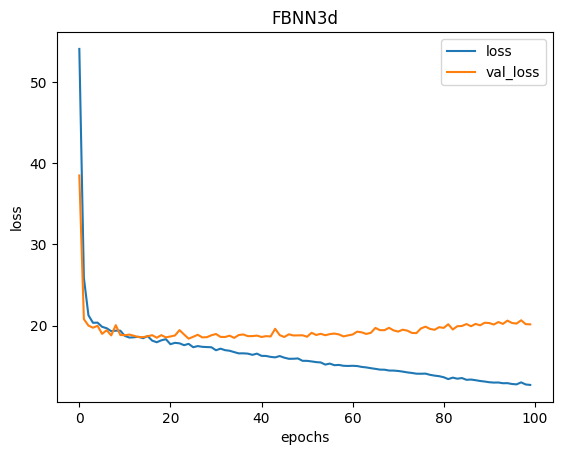

In [12]:
(x_train,y_train) = gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=3000,multi=1000)
test_data = [gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=20,multi=1000) for _ in range(10)]

model = set_model_3d(n_hidden=1100,n_layer=5,print_summary=False)
history = model.fit(x_train, y_train, verbose=0, epochs=100, validation_split=0.2, shuffle=True
                    # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                    )
model.save('./models/mymodel_3d1.h5', include_optimizer=False)

scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
score = np.mean(scores,axis=0)
print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

(x_test, y_test) = gene_data_3d(normalize=False,eig0=None,gene_size=100,multi=1000)
mean_res = comp_logL_Sigmu_3d(model,x_test,y_test)["T-0"]
print("logL diff:",mean_res)

fig, axes = plt.subplots()
df1=pd.DataFrame(history.history)[['loss', 'val_loss']]
df1.plot(ax=axes,xlabel="epochs",ylabel="loss",title="FBNN3d")
plt.show()
# Test loss,Test mae: 23.284274, 3.583585
# logL diff: 4.785290188221497

Normalized

/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss,Test mae: 16.643111, 3.030115
logL diff: 3.2556733922831076


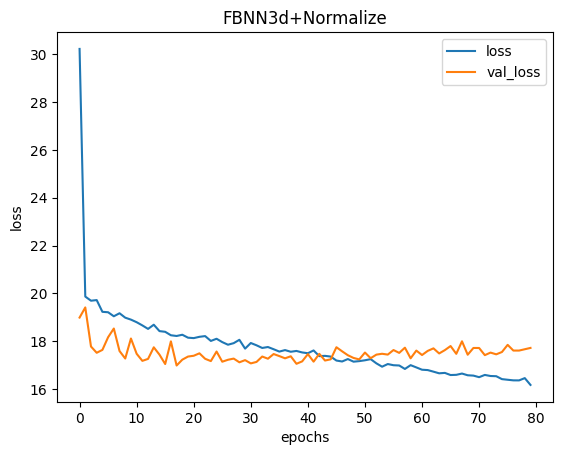

In [13]:
(x_train,y_train) = gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=3000,multi=1000,normalize=True)
test_data = [gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=20,multi=1000,normalize=True) for _ in range(10)]

model = set_model_3d(n_hidden=1100,n_layer=5,print_summary=False)
history = model.fit(x_train, y_train, verbose=0, epochs=80, validation_split=0.2, shuffle=True
                    # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                    )
model.save('./models/mymodel_3d2.h5', include_optimizer=False)

scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
score = np.mean(scores,axis=0)
print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

(x_test, y_test) = gene_data_3d(normalize=True,eig0=None,gene_size=100,multi=1000)
mean_res = comp_logL_Sigmu_3d(model,x_test,y_test)["T-0"]
print("logL diff:",mean_res)

fig, axes = plt.subplots()
df2=pd.DataFrame(history.history)[['loss', 'val_loss']]
df2.plot(ax=axes,xlabel="epochs",ylabel="loss",title="FBNN3d+Normalize")
plt.show()
# 1.9
# 3.532182619824616
# 2.779944626799588

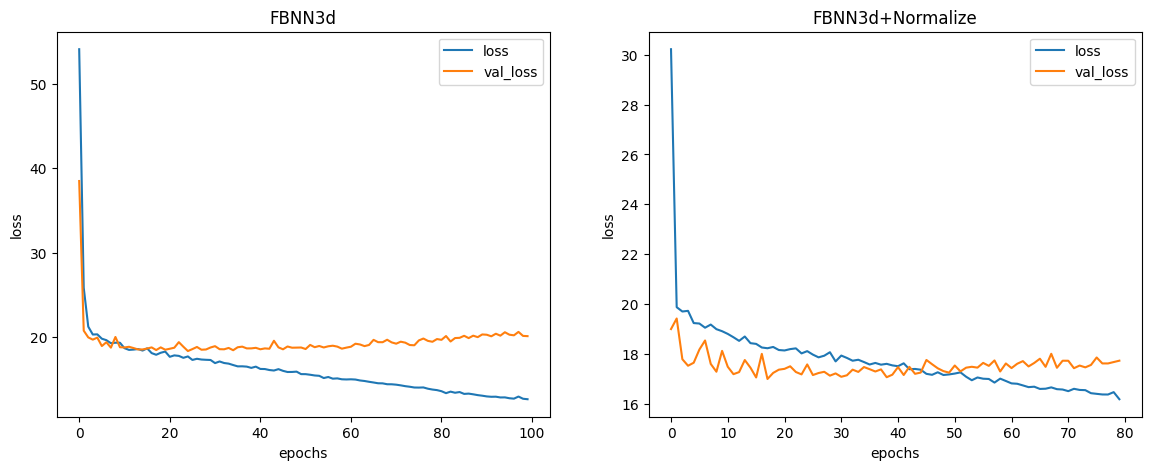

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
df1.plot(ax=axes[0],xlabel="epochs",ylabel="loss",title="FBNN3d")
df2.plot(ax=axes[1],xlabel="epochs",ylabel="loss",title="FBNN3d+Normalize")

plt.show()

## eig[0]=2, 0

non Normalize :


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss,Test mae: 24.119342, 3.619208
logL diff: 4.526151243340555
Normalize :


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss,Test mae: 21.517331, 3.400245
logL diff: 2.6661220529968683


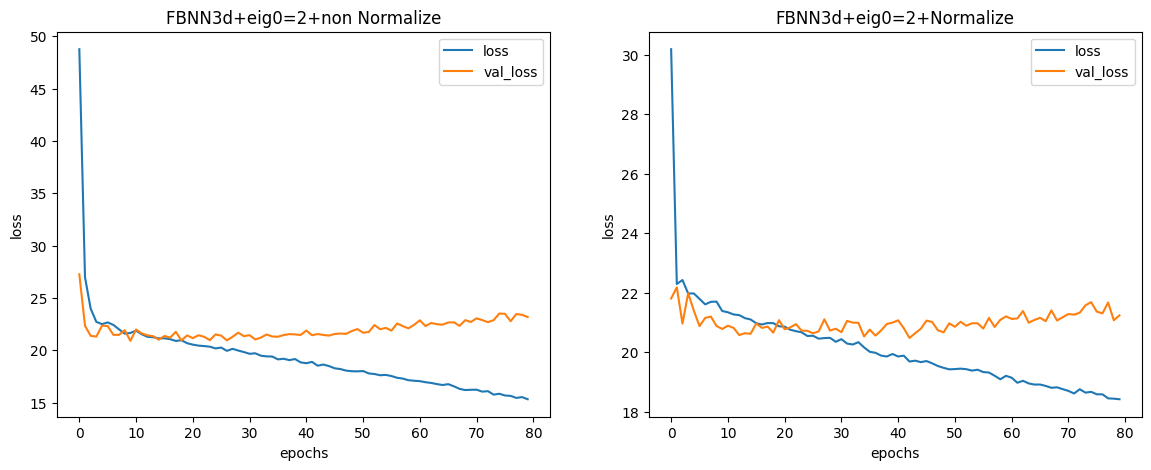

In [8]:
eig0=2
title=["non Normalize","Normalize"]
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i,norm in enumerate([False,True]):
    print(title[i],":")
    (x_train,y_train) = gene_data_3d(normalize=norm,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=3000,multi=1000)
    test_data =        [gene_data_3d(normalize=norm,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=20,multi=100) for _ in range(10)]

    model = set_model_3d(n_hidden=1100,n_layer=5,print_summary=False)
    history = model.fit(x_train, y_train, verbose=0, epochs=80, validation_split=0.2, shuffle=True
                        # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                        )
    model.save("./models/mymodel_3d%d.h5"%(i+3), include_optimizer=False)

    scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
    score = np.mean(scores,axis=0)
    print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

    (x_test, y_test) = gene_data_3d(normalize=norm,eig0=None,gene_size=100,multi=1000)
    mean_res = comp_logL_Sigmu_3d(model,x_test,y_test)["T-0"]
    print("logL diff:",mean_res)

    df=pd.DataFrame(history.history)[['loss', 'val_loss']]
    df.plot(ax=axes[i],xlabel="epochs",ylabel="loss",title="FBNN3d+eig0=2+"+title[i])
plt.show()
# Test loss,Test mae: 26.385997, 3.664266
# logL diff: 3.9584342480557426
# Test loss,Test mae: 23.271177, 3.519957
# logL diff: 2.150373108203145
# Test loss,Test mae: 25.365104, 3.738073
# logL diff: 3.095991142465691
# Test loss,Test mae: 21.134272, 3.383760
# logL diff: 2.551195713555968

non Normalize :
Test loss,Test mae: 37.154447, 4.158948
logL diff: 3.502770641914416
Normalize :
Test loss,Test mae: 33.147847, 4.028454
logL diff: 2.540692575785352


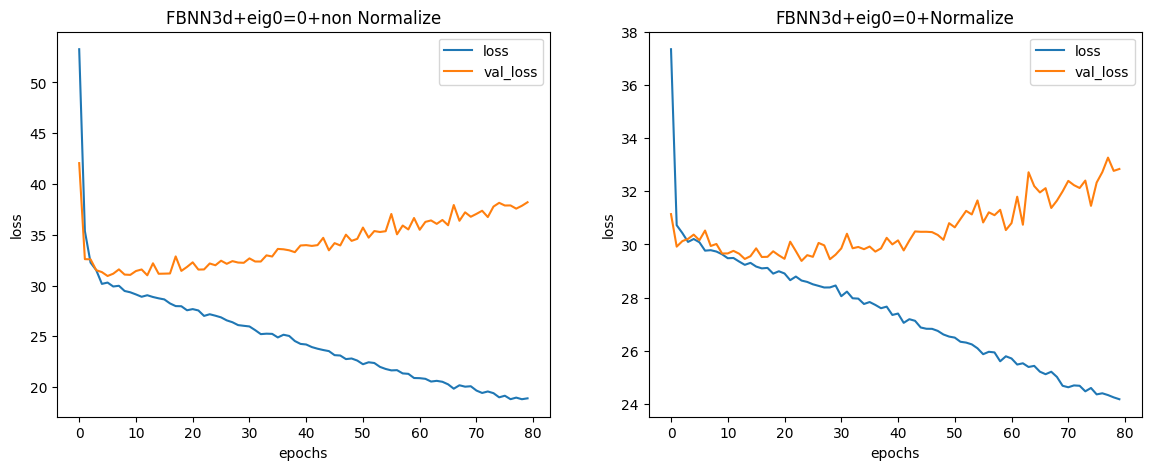

In [9]:
eig0=0
title=["non Normalize","Normalize"]
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i,norm in enumerate([False,True]):
    print(title[i],":")
    (x_train,y_train) = gene_data_3d(normalize=norm,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=3000,multi=1000)
    test_data =        [gene_data_3d(normalize=norm,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=20,multi=1000) for _ in range(10)]

    model = set_model_3d(n_hidden=1100,n_layer=5,print_summary=False)
    history = model.fit(x_train, y_train, verbose=0, epochs=80, validation_split=0.2, shuffle=True
                        # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                        )

    scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
    score = np.mean(scores,axis=0)
    print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

    (x_test, y_test) = gene_data_3d(normalize=norm,eig0=None,gene_size=100,multi=1000)
    mean_res = comp_logL_Sigmu_3d(model,x_test,y_test)["T-0"]
    print("logL diff:",mean_res)

    df=pd.DataFrame(history.history)[['loss', 'val_loss']]
    df.plot(ax=axes[i],xlabel="epochs",ylabel="loss",title="FBNN3d+eig0=0+"+title[i])
plt.show()
# Test loss,Test mae: 37.320180, 4.296016
# logL diff: 3.553953171109972
# Test loss,Test mae: 33.484074, 4.082029
# logL diff: 1.5369586033667286
# non Normalize :
# Test loss,Test mae: 39.043139, 4.415908
# logL diff: 4.353623683693185
# Normalize :
# Test loss,Test mae: 32.038762, 3.972995
# logL diff: 2.2950471724320916

# Resnet

1. ResNet50(畳み込みあり)

Test loss,Test mae: 47.052927, 4.422355


/mnt/c/file/github/fbnn/sei_kume.py:38: RuntimeWarning: overflow encountered in scalar multiply
  dG[j][1+i] = a1*Gth[i] + a2*Gth[j] + a3*Gxi[i] + a4*Gxi[j]
/mnt/c/file/github/fbnn/sei_kume.py:38: RuntimeWarning: invalid value encountered in scalar add
  dG[j][1+i] = a1*Gth[i] + a2*Gth[j] + a3*Gxi[i] + a4*Gxi[j]
/mnt/c/file/github/fbnn/sei_kume.py:38: RuntimeWarning: overflow encountered in scalar add
  dG[j][1+i] = a1*Gth[i] + a2*Gth[j] + a3*Gxi[i] + a4*Gxi[j]
/mnt/c/file/github/fbnn/sei_kume.py:202: RuntimeWarning: invalid value encountered in matmul
  G_rhs = v @ dG


logL diff: 34.49670283457777


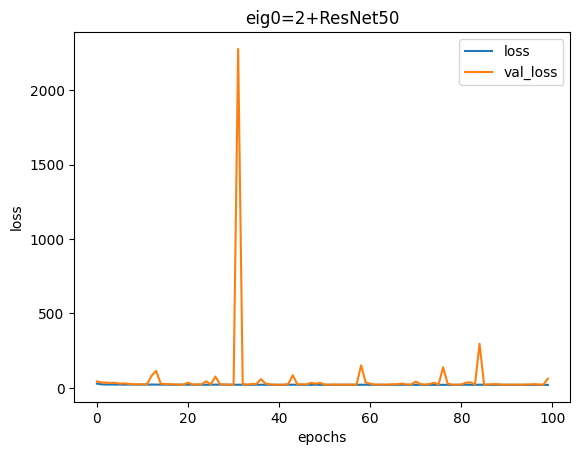

In [15]:
eig0=2
out_shape=(10,10)
(x_train,y_train) = gene_data_3d(out_shape=out_shape,normalize=True,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=3000,multi=1000)
test_data =        [gene_data_3d(out_shape=out_shape,normalize=True,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=20,multi=1000) for _ in range(10)]

model = set_model_resnet50_3d(print_summary=False)
history = model.fit(x_train, y_train, verbose=0, epochs=100, validation_split=0.2, shuffle=True
                    # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                    )
# model.save('mymodel_resnet_3d.h5')#, include_optimizer=False)

scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
score = np.mean(scores,axis=0)
print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

(x_test, y_test) = gene_data_3d(out_shape=out_shape,normalize=True,eig0=None,gene_size=100,multi=1000)
mean_res = comp_logL_Sigmu_3d(model,x_test,y_test)["T-0"]
print("logL diff:",mean_res)

fig, axes = plt.subplots()
df1=pd.DataFrame(history.history)[['loss', 'val_loss']]
df1.plot(ax=axes,xlabel="epochs",ylabel="loss",title="eig0=2+ResNet50")
plt.show()

2. myResNet50(畳み込みなし)

Test loss,Test mae: 25.403645, 3.740400
logL diff: 2.425710935743861


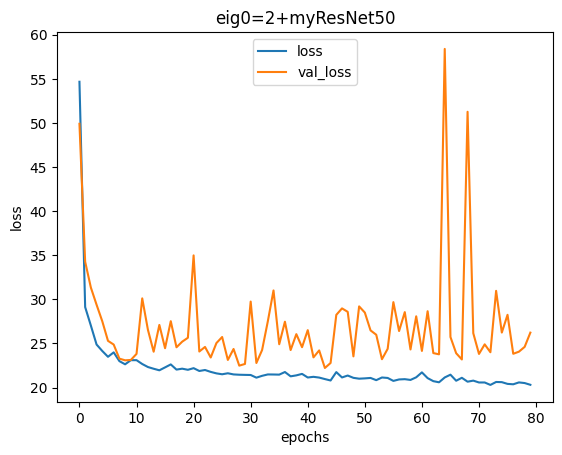

In [23]:
eig0=2
(x_train,y_train) = gene_data_3d(normalize=True,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=3000,multi=100)
test_data =        [gene_data_3d(normalize=True,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=20,multi=100) for _ in range(3)]

model = build((100,), 9, 1000,hidden_layer=50)

model.compile(loss='mse',optimizer='adam',metrics=['mae'])
history = model.fit(x_train, y_train, verbose=0, epochs=80, validation_split=0.2, shuffle=True
                    # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                    )

scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
score = np.mean(scores,axis=0)
print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

(x_test, y_test) = gene_data_3d(normalize=True,eig0=None,gene_size=100,multi=1000)
mean_res = comp_logL_Sigmu_3d(model,x_test,y_test)["T-0"]
print("logL diff:",mean_res)

fig, axes = plt.subplots()
df2=pd.DataFrame(history.history)[['loss', 'val_loss']]
df2.plot(ax=axes,xlabel="epochs",ylabel="loss",title="eig0=2+myResNet50")
plt.show()
# Test loss,Test mae: 24.723227, 3.762312
# logL diff: 4.839029590322436
# Test loss,Test mae: 28.495091, 3.871200
# logL diff: 7.4045095979848705
# 500layer
# Test loss,Test mae: 22.412657, 3.433864
# logL diff: 3.3321191336963283
# 1000layer
# Test loss,Test mae: 25.403645, 3.740400
# logL diff: 2.425710935743861

3. myResNet18(畳み込みなし)

Test loss,Test mae: 23.931919, 3.563287
logL diff: 3.400653414737077


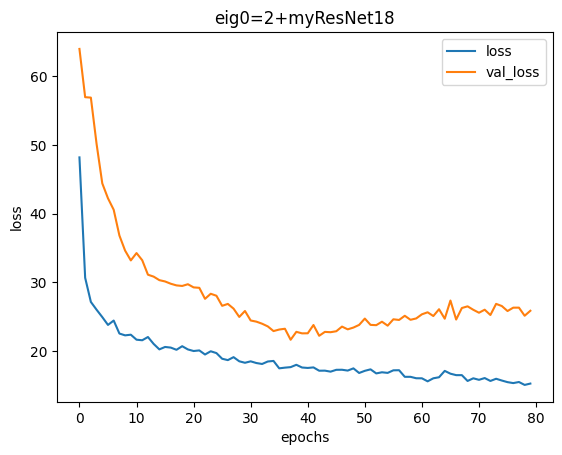

In [17]:
eig0=2
(x_train,y_train) = gene_data_3d(normalize=True,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=500,multi=100)
test_data =        [gene_data_3d(normalize=True,eig0=eig0,Sig_lim=20,mu_lim=20,gene_size=20,multi=100) for _ in range(3)]

model = build((100,), 9, 1000,hidden_layer=18)

model.compile(loss='mse',optimizer='adam',metrics=['mae'])
history = model.fit(x_train, y_train, verbose=0, epochs=80, validation_split=0.2, shuffle=True
                    # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                    )

scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
score = np.mean(scores,axis=0)
print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

(x_test, y_test) = gene_data_3d(normalize=True,eig0=None,gene_size=100,multi=1000)
mean_res = comp_logL_Sigmu_3d(model,x_test,y_test)["T-0"]
print("logL diff:",mean_res)

fig, axes = plt.subplots()
df3=pd.DataFrame(history.history)[['loss', 'val_loss']]
df3.plot(ax=axes,xlabel="epochs",ylabel="loss",title="eig0=2+myResNet18")
plt.show()
# Test loss,Test mae: 27.279338, 3.945507
# logL diff: 4.024310334651856

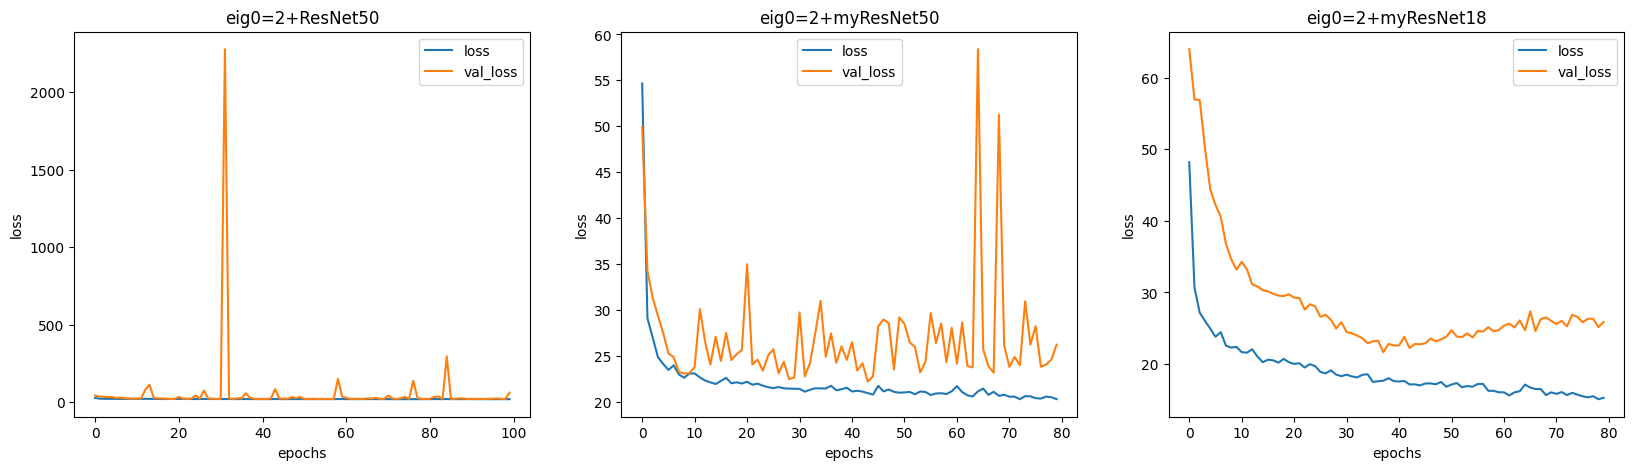

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
titles=["eig0=2+ResNet50","eig0=2+myResNet50","eig0=2+myResNet18"]

for i,df in enumerate([df1,df2,df3]):
    df.plot(ax=axes[i],xlabel="epochs",ylabel="loss",title=titles[i])

plt.show()